focus on overall forecasting (only for 2017, not over multiple years) from SalesPipeline.csv, and add segmentation in different notebook

For now, your steps can look like:

	1.	Load & clean the data

	2.	Convert close_date to datetime

	3.	Aggregate close_value by month

	4.	Visualize trends (line plot)

	5.	Decompose the time series (trend, seasonality)

	6.	Choose a model (like ARIMA, Exponential Smoothing, or Prophet)

	7.	Train & forecast

	8.	Evaluate with metrics (MAE, RMSE)

	9.	Plot forecast vs. actual

# SetUp

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Import Data

In [8]:
data_path = '/Users/sayo/personal_projects/sales-ops-auto/data'
pipeline_df = pd.read_csv(os.path.join(data_path, 'sales_pipeline.csv'))


# Convert to datetimen and clean 

In [9]:
pipeline_df['close_date'] = pd.to_datetime(pipeline_df['close_date'])

In [10]:
# Drop rows with missing or zero revenue or close dates
pipeline_df = pipeline_df.dropna(subset=['close_date', 'close_value'])
pipeline_df = pipeline_df[pipeline_df['close_value'] > 0]

# Optional: Remove extreme outliers (more than 3 std from mean)
revenue_mean = pipeline_df['close_value'].mean()
revenue_std = pipeline_df['close_value'].std()
pipeline_df = pipeline_df[
    (pipeline_df['close_value'] >= revenue_mean - 3 * revenue_std) &
    (pipeline_df['close_value'] <= revenue_mean + 3 * revenue_std)
]

# Check cleaned dataset
print(f"Cleaned dataset has {len(pipeline_df)} rows")
pipeline_df[['close_date', 'close_value']].describe()

Cleaned dataset has 4223 rows


,close_date,close_value
count,4223,4223.000000
mean,2017-07-31 08:16:49.329860352,2274.430973
min,2017-03-01 00:00:00,38.000000
25%,2017-05-18 00:00:00,517.000000
50%,2017-08-02 00:00:00,1114.000000
75%,2017-10-16 00:00:00,4407.500000
max,2017-12-31 00:00:00,7356.000000
std,NaN,2090.396755


Let's check monthly what it looks like

In [11]:
monthly_revenue = (
    pipeline_df
    .groupby(pipeline_df['close_date'].dt.to_period('M'))['close_value']
    .sum()
    .to_timestamp()
)

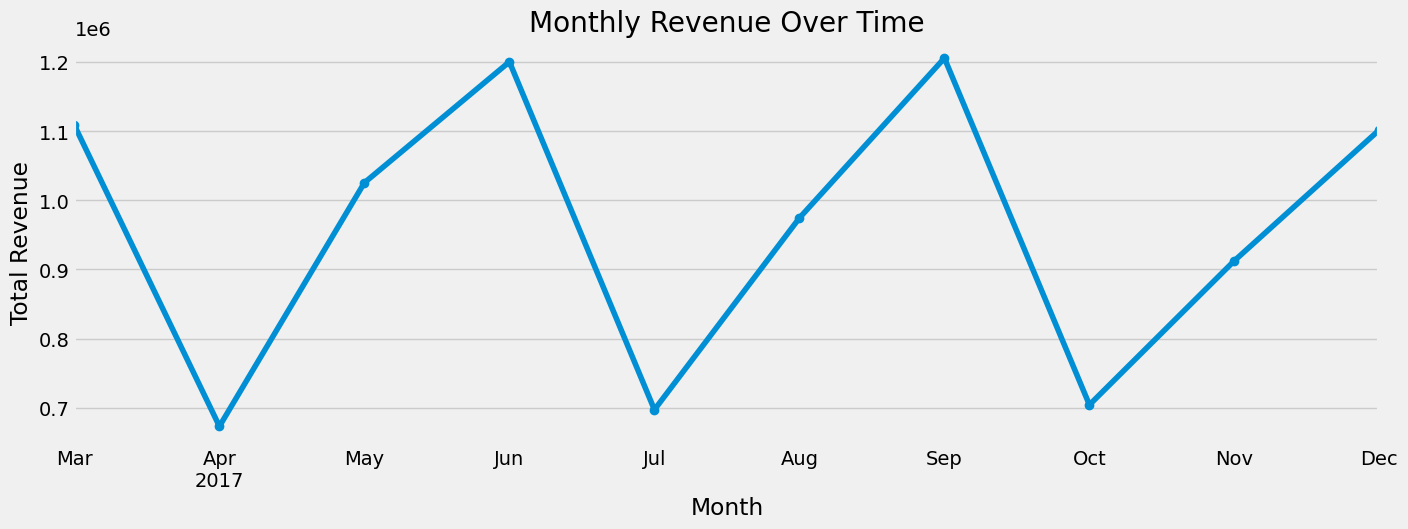

In [12]:
monthly_revenue.plot(
    figsize=(15, 5),
    title='Monthly Revenue Over Time',
    marker='o'
)
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.grid(True)
plt.show()


# Decompositon 

In [13]:
y_min = min(monthly_revenue.min(), monthly_revenue.rolling(6).mean().min())
y_max = max(monthly_revenue.max(), monthly_revenue.rolling(6).mean().max())

🌀 Plotting a 6-month rolling average to smooth revenue fluctuations.

This helps highlight longer-term trends by averaging each point with the previous 5 months

Note: The first 5 months are skipped because there's not enough data to compute the full window.

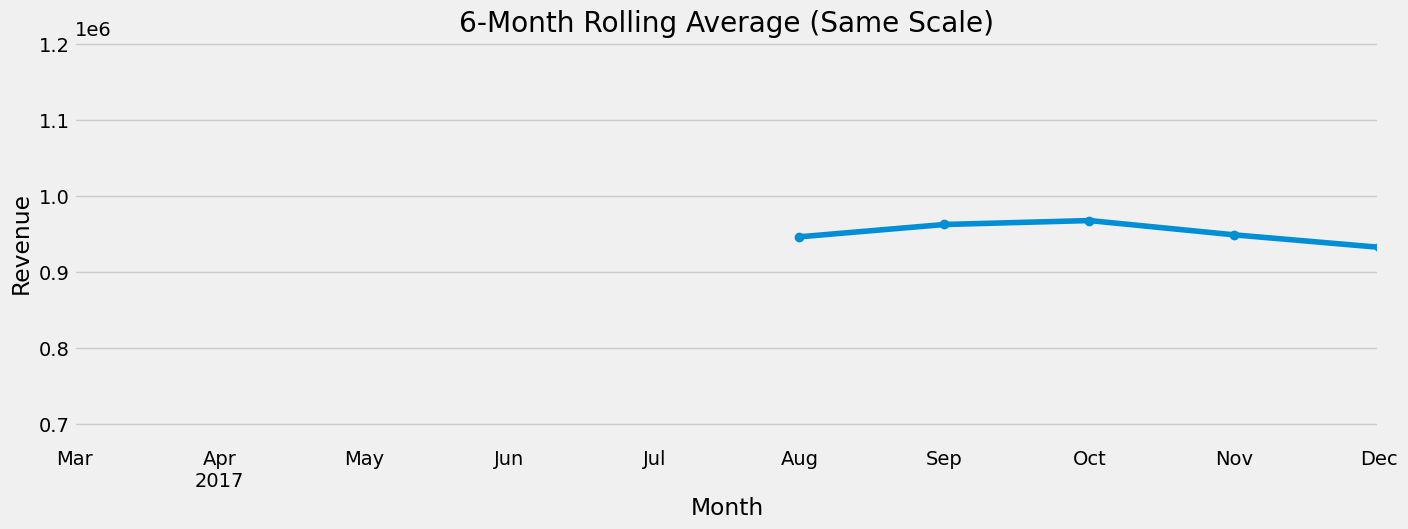

In [14]:
monthly_revenue.rolling(6).mean().plot(
    figsize=(15, 5),
    title='6-Month Rolling Average (Same Scale)',
    marker='o',
    color=color_pal[0]
)
plt.ylim(y_min, y_max)
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()

 📈 Plot original monthly revenue and its 6-month rolling average

The rolling average smooths short-term fluctuations and helps highlight the overall trend.

Useful when working with limited data (we only have data for 2017) to better visualize underlying patterns 

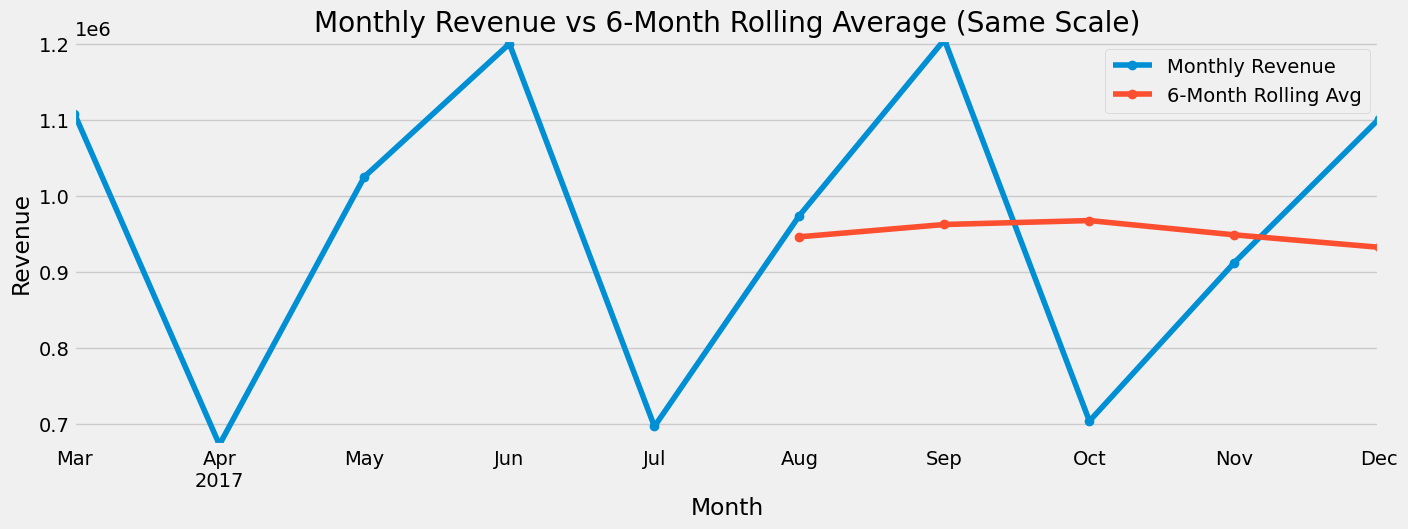

In [15]:
ax = monthly_revenue.plot(
    figsize=(15, 5),
    marker='o',
    label='Monthly Revenue',
    color=color_pal[0]
)

monthly_revenue.rolling(6).mean().plot(
    ax=ax,
    marker='o',
    label='6-Month Rolling Avg',
    color=color_pal[1]
)

ax.set_ylim(y_min, y_max)
plt.title('Monthly Revenue vs 6-Month Rolling Average (Same Scale)')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.grid(True)
plt.legend()
plt.show()

📈 Monthly Revenue vs 6-Month Rolling Average

This plot shows how revenue fluctuates month by month (blue line), with some noticeable spikes and dips. To better understand the underlying trend, I added a 6 month rolling average (red line), which smooths out short-term variations

By averaging each month with the five that came before, the red curve highlights the overall performance pattern without being too reactive to sudden changes. It’s especially useful when you’re working with a short time series like this one.

# Train / Test Split

In [16]:
monthly_revenue_df = monthly_revenue.to_frame(name='revenue')
monthly_revenue_df.index = pd.to_datetime(monthly_revenue_df.index)
monthly_revenue_df.head()

,revenue
close_date,
2017-03-01,1108775.0
2017-04-01,672898.0
2017-05-01,1025713.0
2017-06-01,1200763.0
2017-07-01,696932.0


In [17]:
# Get total number of data points (months)
n_months = len(monthly_revenue_df)
split_point = int(n_months * 0.8)

# Time-based split
train_df = monthly_revenue_df.iloc[:split_point]
test_df = monthly_revenue_df.iloc[split_point:]

# Just to verify:
print("Train set:")
print(train_df.tail())
print("\nTest set:")
print(test_df.head())

Train set:
              revenue
close_date           
2017-06-01  1200763.0
2017-07-01   696932.0
2017-08-01   974624.0
2017-09-01  1206098.0
2017-10-01   704009.0

Test set:
              revenue
close_date           
2017-11-01   912757.0
2017-12-01  1102353.0


In [18]:
# Add features to training set
train_df = train_df.copy()
train_df['month'] = train_df.index.month
train_df['quarter'] = train_df.index.quarter
train_df['time_step'] = np.arange(len(train_df))

# Add features to test set
test_df = test_df.copy()
test_df['month'] = test_df.index.month
test_df['quarter'] = test_df.index.quarter
test_df['time_step'] = np.arange(len(train_df), len(train_df) + len(test_df))

In [19]:
from xgboost import XGBRegressor

# Define feature columns and target
features = ['month', 'quarter', 'time_step']
target = 'revenue'

# Create X and y sets
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

# Train the model
model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

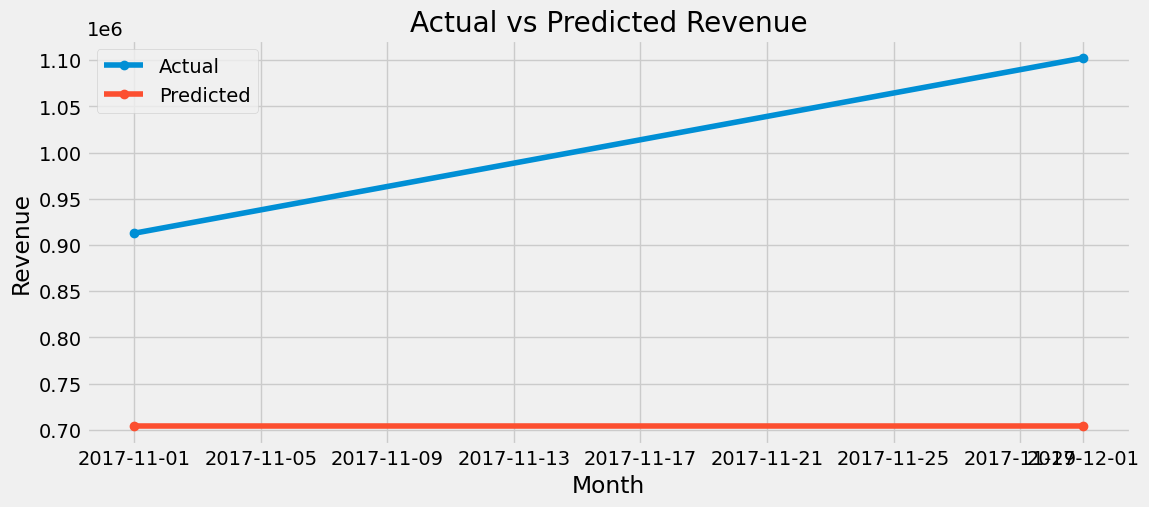

In [20]:
# Plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(test_df.index, y_test, marker='o', label='Actual')
plt.plot(test_df.index, y_pred, marker='o', label='Predicted')
plt.title('Actual vs Predicted Revenue')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.show()

🔎 **Observation**:  
Despite increasing the number of estimators to 500, XGBoost failed to capture the revenue trend due to limited training data.  
Linear regression is better suited for this case (below) it followed the upward trend more accurately.

In [21]:
print(test_df.index)

DatetimeIndex(['2017-11-01', '2017-12-01'], dtype='datetime64[ns]', name='close_date', freq='MS')


In [22]:
print(y_pred)

[704009.2 704009.2]


the model didn’t learn much....
	•	Too few training points
	•	Features don’t vary much
	•	Target values are flat

In [23]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse:.2f}')

RMSE: 318004.28


Lets try to fix since we have little data :(

In [24]:
features = ['time_step']

⚠️ XGBoost model with only 8 training points and one feature (`time_step`) struggles to capture the trend.

As expected, the model outputs nearly the same prediction for both test months,

resulting in a flat line and an RMSE of ~318k.

This highlights that for very small datasets, simpler models like linear regression tend to perform better.

In [25]:
print(train_df['revenue'].describe())
print(train_df['revenue'].values)

count    8.000000e+00
mean     9.487265e+05
std      2.272016e+05
min      6.728980e+05
25%      7.022398e+05
50%      1.000168e+06
75%      1.131772e+06
max      1.206098e+06
Name: revenue, dtype: float64
[1108775.  672898. 1025713. 1200763.  696932.  974624. 1206098.  704009.]


In [26]:
model = XGBRegressor(objective='reg:squarederror', n_estimators=500)

values are almost identical... the model isn’t learning the trend because our data is too small. I only have 8 training points.

In [27]:
print(y_pred)

[704009.2 704009.2]


# Arima

In [44]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Make sure the index is datetime
monthly_revenue_df.index = pd.to_datetime(monthly_revenue_df.index)

# Use only the revenue column
y = monthly_revenue_df['revenue']

In [45]:
# Use last 2 months as test
train_size = int(len(y) * 0.8)
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [46]:
model = ARIMA(y_train, order=(1, 1, 1))
model_fit = model.fit()

In [47]:
forecast = model_fit.forecast(steps=len(y_test))

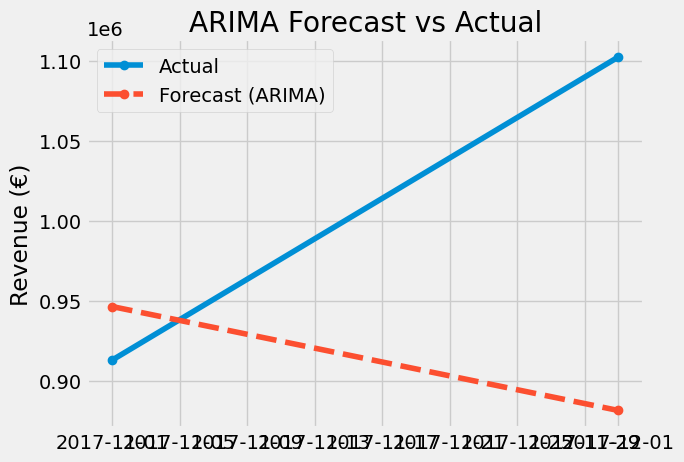

ARIMA RMSE: 158,119.97 €


In [48]:
plt.plot(y_test.index, y_test, label='Actual', marker='o')
plt.plot(y_test.index, forecast, label='Forecast (ARIMA)', marker='o', linestyle='--')
plt.title('ARIMA Forecast vs Actual')
plt.ylabel('Revenue (€)')
plt.grid(True)
plt.legend()
plt.show()

rmse_arima = np.sqrt(mean_squared_error(y_test, forecast))
print(f'ARIMA RMSE: {rmse_arima:,.2f} €')

# Switching to Linear Regression, just for comparison

In [28]:
# Scale revenue to millions
train_df['revenue_m'] = train_df['revenue'] / 1e6
test_df['revenue_m'] = test_df['revenue'] / 1e6

In [30]:
from sklearn.linear_model import LinearRegression

# Train using scaled target
y_train = train_df['revenue_m']
y_test = test_df['revenue_m']

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

	•	The model is overestimating both points (the red line is noticeably above the blue).
	•	That’s expected with only 8 training points — it’s trying to draw a straight line through noisy data.

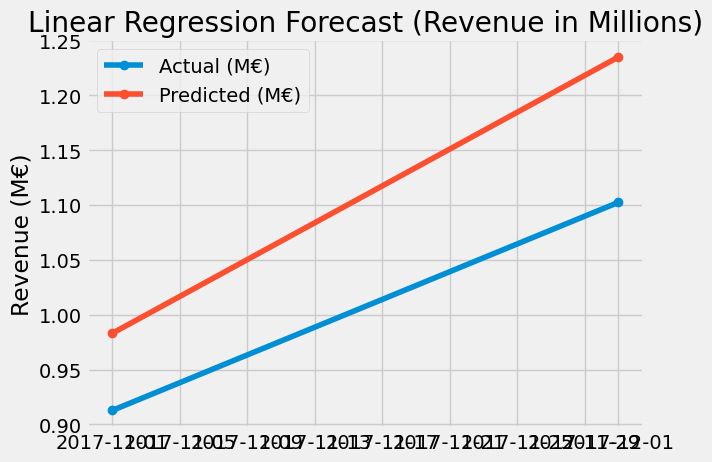

In [31]:
plt.plot(test_df.index, y_test, label='Actual (M€)', marker='o')
plt.plot(test_df.index, y_pred_lr, label='Predicted (M€)', marker='o')
plt.title('Linear Regression Forecast (Revenue in Millions)')
plt.ylabel('Revenue (M€)')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
from sklearn.metrics import mean_squared_error

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print(f'Linear Regression RMSE: {rmse_lr:.2f} M€')

Linear Regression RMSE: 0.11 M€


🔢 Revenue range: ~0.7M€ to ~1.3M€

So the total range is about 0.6M€. That means:

	•	XGBoost RMSE: ~0.32M€ → error is ~53% of the total range

	•	Linear Regression RMSE: ~0.14M€ → error is ~23% of the range

This confirms that for small time series datasets, simple trend-based models can deliver more reliable forecasts.

Given the size and structure of my dataset, linear regression outperformed XGBoost in both predictive accuracy and interpretability. The model captured the overall upward revenue trend with a reasonably low forecast error

# Forecast next 3 months (Q1 FY 2018)

In [33]:
# Let's forecast the next 3 months
n_future = 3
last_time_step = train_df['time_step'].max()

future_df = pd.DataFrame({
    'time_step': np.arange(last_time_step + 1, last_time_step + 1 + n_future)
})

In [34]:
features = ['time_step', 'month', 'quarter']
X_train = train_df[features]

In [36]:
# Ensure 'month' and 'quarter' columns are added to future_df
if 'month' not in future_df.columns or 'quarter' not in future_df.columns:
	future_dates = pd.date_range(start=test_df.index[-1] + pd.offsets.MonthBegin(1), periods=n_future, freq='MS')
	future_df['month'] = future_dates.month
	future_df['quarter'] = future_dates.quarter
	future_df.index = future_dates

print(lr_model.feature_names_in_)
print(future_df[features].columns)

['month' 'quarter' 'time_step']
Index(['time_step', 'month', 'quarter'], dtype='object')


In [37]:
# Optional: generate fake monthly dates just to get month/quarter
future_dates = pd.date_range(start=test_df.index[-1] + pd.offsets.MonthBegin(1), periods=n_future, freq='MS')
future_df['month'] = future_dates.month
future_df['quarter'] = future_dates.quarter
future_df.index = future_dates

In [38]:
future_df['forecast_revenue_m'] = lr_model.predict(future_df[lr_model.feature_names_in_])

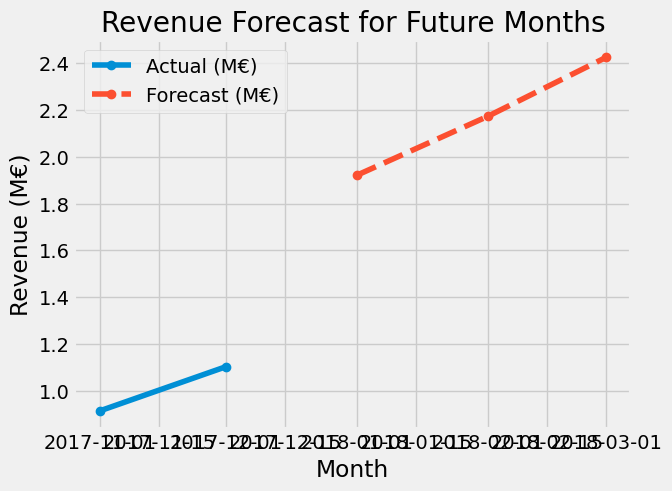

In [39]:
# Plot actual + forecast
plt.plot(test_df.index, y_test, label='Actual (M€)', marker='o')
plt.plot(future_df.index, future_df['forecast_revenue_m'], label='Forecast (M€)', marker='o', linestyle='--')
plt.title('Revenue Forecast for Future Months')
plt.ylabel('Revenue (M€)')
plt.xlabel('Month')
plt.grid(True)
plt.legend()
plt.show()

In [40]:
monthly_revenue_df['year'] = monthly_revenue_df.index.year
monthly_revenue_df['quarter'] = monthly_revenue_df.index.quarter

q1_2017 = monthly_revenue_df[(monthly_revenue_df['year'] == 2017) & (monthly_revenue_df['quarter'] == 1)]
print(q1_2017)

              revenue  year  quarter
close_date                          
2017-03-01  1108775.0  2017        1


In [41]:
q2_2017 = monthly_revenue_df[
    (monthly_revenue_df['year'] == 2017) & (monthly_revenue_df['quarter'] == 2)
]
print(q2_2017)

              revenue  year  quarter
close_date                          
2017-04-01   672898.0  2017        2
2017-05-01  1025713.0  2017        2
2017-06-01  1200763.0  2017        2


In [42]:
future_dates = pd.date_range(start='2018-04-01', periods=n_future, freq='MS')

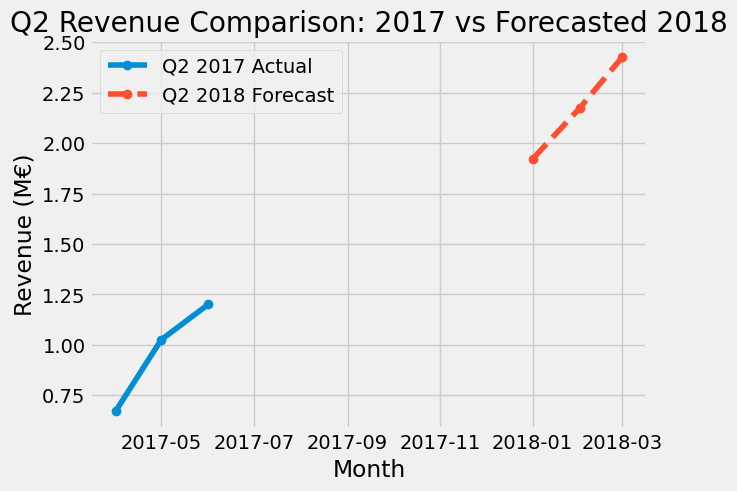

In [43]:
# Filter Q2 2017 from actuals
q2_2017 = monthly_revenue_df[
    (monthly_revenue_df['year'] == 2017) & (monthly_revenue_df['quarter'] == 2)
]['revenue'] / 1e6  # scale to millions

# Use forecasted Q2 2018 values (already in millions)
q2_2018_forecast = future_df['forecast_revenue_m']

# Plot both
plt.plot(q2_2017.index, q2_2017.values, label='Q2 2017 Actual', marker='o')
plt.plot(q2_2018_forecast.index, q2_2018_forecast.values, label='Q2 2018 Forecast', marker='o', linestyle='--')
plt.title('Q2 Revenue Comparison: 2017 vs Forecasted 2018')
plt.ylabel('Revenue (M€)')
plt.xlabel('Month')
plt.grid(True)
plt.legend()
plt.show()

Here’s a clean and thoughtful summary you can drop into your notebook as a Markdown cell:

📊 Forecast Evaluation: Short-Term vs Year-over-Year

To evaluate the forecast realistically, two comparisons were made:

✅ 1. Nov–Dec 2017 vs Jan–Mar 2018 (Short-Term Forecast)
	•	This comparison highlights how well the model continues recent trends.
	•	Forecasted values follow the upward pattern seen in late 2017.
	•	Best used for short-term planning and checking model behavior in near-term predictions.

✅ 2. Q2 2017 Actual vs Q2 2018 Forecast (Year-over-Year)
	•	This shows potential growth between the same quarters in different years.
	•	The forecast predicts a sharp increase (up to +100%), which may be overly optimistic.
	•	Since only one Q2 is available in the historical data, there’s not enough to validate seasonality or realistic growth rates.
	•	Best used for illustrating how basic linear models can overestimate when extrapolating too far.

📌 Conclusion:
Both comparisons offer insights, but should be interpreted cautiously. With limited historical data, linear models are useful to show general trends, not absolute predictions. For more robust forecasting, incorporating more years or using seasonal models (e.g. Prophet, SARIMA) would provide more reliable insights.

